<a href="https://colab.research.google.com/github/NicolasToncheis/Manufatura/blob/main/CAE_RedutorVelocidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.linalg as la

#Propriedades definidas pelo grupo:
Red = 6 #Redução requerida
Ts = 1030 #N.m, na saída do redutor
Rot = 1800 #Rpm, na entrada do redutor, no Par de Engrenagens 1

#Propriedades do engrenamento:
AP = 25*(np.pi/180) #Ângulo de pressão em radianos
N = math.sqrt(Red) #Redução por cada par
AH = 20*(np.pi/180) #Ângulo de hélice em radianos
#Por análise conforme Norton 12-2:
Np = 20 #Número de dentes no pinhão
Ng = 49 #Número de dentes na engrenagem
pd = 4 #Dentes/m
dpp = (Np/pd)*0.0254 #Diâmetro primitivo dos pinhões em m
dpg = (Ng/pd)*0.0254 #Diâmetro primitivo das engrenagens em m

#Análise de Forças nas engrenagens dos eixos:
Tc = Ts/N #No Eixo Central
Te = Tc/N #No Eixo de Entrada

#Para o Par 1:
Wt1 = Te/(dpp/2) #Força tangencial em N
Wr1 = Wt1*math.tan(AP) #Força radial em N
Wa1 = Wt1*math.tan(AH) #Força axial em N

#Para o Par 2:
Wt2 = Tc/(dpp/2) #Força tangencial em N
Wr2 = Wt2*math.tan(AP) #Força radial em N
Wa2 = Wt2*math.tan(AH) #Força axial em N

#Momentos causados pelas engrenagens no Eixo Y:
M1 = -62.48158597 #N.m
M2 = -153.048 #N.m
M3 = -153.048 #N.m
M4 = -374.9676096 #N.m

print(Te, Tc, Ts, M1, M2, M3, M4)

print(Wt1, Wr1, Wa1, Wt2, Wr2, Wa2)

171.66666666666669 420.49573917777894 1030 -62.48158597 -153.048 -153.048 -374.9676096
2703.412073490814 1260.6217530174504 983.9615257065313 6621.980144531952 3087.8800535455935 2410.203664511435


ELEMENTOS FINITOS

Eixo de Entrada: 2 elementos e 3 nós com 6 gdl.

In [ ]:
import numpy as np

# Dados de entrada
v = 0.3 #Coeficiente de Poisson
E = 210e9 # Módulo de elasticidade
ReE = (1.771733886/2)*0.0254 #Em m
A = np.pi*(ReE**2) # area da secção transversal
I1 = (np.pi*(ReE**4))/4 # momento de inércia da secção
J1 = 2*I1 #Momento polar de inércia
G = E/(2*(1+v)) #Modulo de elasticidade transversal
# Discretização
nnode = 3  # numero total de nos
nel = 2 # numero total de elementos
nnel = 2 # numero de nos por elemento
ndof = 6 #numero de GDL por no
edof = nnel*ndof # numero de GDL por elemento
sdof = nnode*ndof #numero total de GDL do sistema
# Coordenadas dos nós
gcoord = np.array([[0,0,0],
                   [0.26,0,0],
                   [0.4,0,0]])
#print(gcoord)
# Matriz de incidência: sempre há dois nós nesse caso
nodes = np.array([[0,1],
                  [1,2]])
# Vetor de forças aplicadas
F = np.array([0,0,0,0,0,0,-Wa1,-Wt1,-Wr1,0,M1,0,0,0,0,0,0,0]) # Cuidado com aplicação!
# Condições de contorno
bcdof = np.array([1,2,3,4,12,13,14]) #Us que eu travo
bcval = np.array([0,0,0,0,0,0,0]) # Valor de deslocamento -> zero para travar
KK = np.zeros((sdof,sdof))
for i in range(0,nel):
    deltax = gcoord[nodes[i,1],0] - gcoord[nodes[i,0],0]
    deltay = gcoord[nodes[i,1],1] - gcoord[nodes[i,0],1]
    #print(deltay)
    # comprimento do elemento
    L = np.sqrt(deltax**2+deltay**2)
    #print(L)
    alfa = np.arctan(deltay/deltax)
    #print(alfa*180/np.pi)
    # Matriz de rigidez do elemento -> PASSAR PARA 3D COM 12X12 E DEPOIS 18X18
    ke = np.array([[A*L**2/I1,0,0,0,0,0,-A*L**2/I1,0,0,0,0,0],
                   [0,12,0,0,0,6*L,0,-12,0,0,0,6*L],
                   [0,0,12,0,-6*L,0,0,0,-12,0,-6*L,0],
                   [0,0,0,L**2/(1+v),0,0,0,0,0,-L**2/(1+v),0,0],
                   [0,0,-6*L,0,4*L**2,0,0,0,6*L,0,2*L**2,0],
                   [0,6*L,0,0,0,4*L**2,0,-6*L,0,0,0,2*L**2],
                   [-A*L**2/I1,0,0,0,0,0,A*L**2/I1,0,0,0,0,0],
                   [0,-12,0,0,0,-6*L,0,12,0,0,0,-6*L],
                   [0,0,-12,0,6*L,0,0,0,12,0,6*L,0],
                   [0,0,0,-L**2/(1+v),0,0,0,0,0,L**2/(1+v),0,0],
                   [0,0,-6*L,0,2*L**2,0,0,0,6*L,0,4*L**2,0],
                   [0,6*L,0,0,0,2*L**2,0,-6*L,0,0,0,4*L**2]])
    ke = ke*E*I1/L**3
    #print(ke)
    # Matriz de rotação
    #c = np.cos(alfa)
    #s = np.sin(alfa)
    T = np.eye(12)
    Tt = np.transpose(T)
    #print(Tt)
    Ke = np.dot(Tt,ke)
    Ke = np.dot(Ke,T)
    #print(Ke)
    #print(np.linalg.det(Ke))
    # montar a matriz de rigidez
    # definir o vetor de indices (index)
    index = np.zeros((1,edof), dtype = int)
    for m in range (0,ndof):
        index[0,m] = 6*nodes[i,0]+m
        index[0,m+ndof] = 6*nodes[i,1]+m
    #print(index)
    # montagem da matriz de rigidez global do sistema
    for j in range (0,edof):
        for k in range (0,edof):
            KK[index[0,j],index[0,k]] = KK[index[0,j],index[0,k]] + Ke[j,k]
    #print(KK)
# numero de condicoes de contorno aplicadas
ncc = bcdof.size
#print(ncc)
KK_cc = KK
#print(KK_cc)
F_cc = F
#print(F_cc)
indice_cc = ncc-1
for n in range (0,ncc):
    KK_cc = np.delete(KK_cc, bcdof[indice_cc],0) # retirar as linhas
    KK_cc = np.delete(KK_cc, bcdof[indice_cc],1) # retirar as colunas
    F_cc = np.delete(F_cc, bcdof[indice_cc],0)
    indice_cc = indice_cc -1
#print(KK_cc)
#print(np.linalg.det(KK_cc))
#print(F_cc)
# resolver a equacao linear
u = np.linalg.solve(KK_cc, F_cc)
print(u)
#indicecc = 0
#indicegdl = 0
#U = np.zeros((1,sdof)) # vetor de deslocamento total
#for i in range (0,sdof):
    #if i == bcdof[indicecc]:
        #U[0,i] = bcval[indicecc]
        #indicecc = indicecc+1
    #else:
        #U[0,i] = u[indicegdl]
        #indicegdl = indicegdl+1
#print(U)
#Ut = np.transpose(U)
#reacao = np.dot(KK,Ut)
#print(reacao)
print(A,I1,J1,G)
#print(np.linalg.det(Ke))

#Em ordem: Rx1, Rotz1, Rx2, Ry2, Rz2, Rotx2, Roty2, Rotz2, Rotx3, Roty3, Rotz3

[-4.12413203e-07 -5.23694635e-04 -4.12413203e-07 -7.06017952e-05
 -1.94736259e-05  0.00000000e+00 -7.41606852e-05  2.32753171e-04
  0.00000000e+00 -1.71565649e-04  6.40071221e-04]
0.001590575533044505 2.0132547447143915e-07 4.026509489428783e-07 80769230769.23077


In [ ]:
# Matriz de Massa para o Eixo de Entrada
rho = 7850  # Densidade em kg/m^3

#Matriz de Massa para um elemento de viga de Euler-Bernoulli
m_e = (rho * A * L / 420) * np.array([
    [140, 0, 0, 0, 0, 0, 70, 0, 0, 0, 0, 0],
    [0, 156, 0, 0, 0, 22*L, 0, 54, 0, 0, 0, -13*L],
    [0, 0, 156, 0, -22*L, 0, 0, 0, 54, 0, 13*L, 0],
    [0, 0, 0, 140*I1/A, 0, 0, 0, 0, 0, 70*I1/A, 0, 0],
    [0, 0, -22*L, 0, 4*(L**2), 0, 0, 0, -13*L, 0, -3*(L**2), 0],
    [0, 22*L, 0, 0, 0, 4*(L**2), 0, 13*L, 0, 0, 0, -3*(L**2)],
    [70, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 0],
    [0, 54, 0, 0, 0, 13*L, 0, 156, 0, 0, 0, -22*L],
    [0, 0, 54, 0, -13*L, 0, 0, 0, 156, 0, 22*L, 0],
    [0, 0, 0, 70*I1/A, 0, 0, 0, 0, 0, 140*I1/A, 0, 0],
    [0, 0, 13*L, 0, -3*(L**2), 0, 0, 0, 22*L, 0, 4*(L**2), 0],
    [0, -13*L, 0, 0, 0, -3*(L**2), 0, -22*L, 0, 0, 0, 4*(L**2)]])

# Montagem da Matrix de Massa Global:
MM = np.zeros((sdof - ncc, sdof - ncc))

for i in range(nel):
    index = np.zeros((1, edof), dtype=int)
    for m in range(ndof):
        index[0, m] = 6 * nodes[i, 0] + m
        index[0, m + ndof] = 6 * nodes[i, 1] + m

    for j in range(edof):
        for k in range(edof):
            MM[index[0, j] - ncc, index[0, k] - ncc] += m_e[j, k]

#Impressão de arrays NumPy mais precisas
#np.set_printoptions(precision=3, suppress=True)

print(np.linalg.det(m_e))
#print(np.linalg.det(MM))
#print(MM)

3.653852204751123e-28


In [ ]:
#!python --version
# Determinação dos autovalores e autovetores do Eixo de Entrada
Autovalor, Autovetor = la.eigh(KK_cc, MM)
Frequency = np.sqrt(Autovalor)/(2*np.pi)

#Em ordem: Rx1, Rotz1, Rx2, Ry2, Rz2, Rotx2, Roty2, Rotz2, Rotx3, Roty3, Rotz3
print(Frequency)
#print(Autovalor)
#print(Autovetor) #Matriz Modal do Eixo de Entrada

[4.96487910e+01 6.90144807e+01 1.17560432e+02 1.72673323e+02
 2.38724424e+02 1.86184886e+03 4.10568915e+03 4.96936843e+03
 1.21472566e+04 1.20228888e+05 8.13702908e+05]


Barra Intermediária:

In [ ]:
# Dados de entrada
v = 0.3 #Coeficiente de Poisson
E = 210e9 # Módulo de elasticidade
ReE = (2.551967501/2)*0.0254 #Em m
A = np.pi*(ReE**2) # area da secção transversal
I2 = (np.pi*(ReE**4))/4 # momento de inércia da secção
J2 = 2*I2 #Momento polar de inércia
G = E/(2*(1+v)) #Modulo de elasticidade transversal
print(A,I2,J2,G)
# Discretização
nnode = 4  # numero total de nos
nel = 3 # numero total de elementos
nnel = 2 # numero de nos por elemento
ndof = 6 #numero de GDL por no
edof = nnel*ndof # numero de GDL por elemento
sdof = nnode*ndof #numero total de GDL do sistema
# Coordenadas dos nós
gcoord = np.array([[0,0,0],
                   [0.16,0,0],
                   [0.26,0,0],
                   [0.4,0,0]])
#print(gcoord)
# Matriz de incidência: sempre há dois nós nesse caso
nodes = np.array([[0,1],
                  [1,2],
                  [2,3]])
# Vetor de forças aplicadas
F = np.array([0,0,0,0,0,0,-Wa2,Wt2,-Wr2,0,M2,0,Wa1,Wt1,Wr1,0,M3,0,0,0,0,0,0,0]) # Cuidado com aplicação!
# Condições de contorno
bcdof = np.array([1,2,3,4,18,19,20]) #Us que eu travo
bcval = np.array([0,0,0,0,0,0,0]) # Valor de deslocamento -> zero para travar
KK = np.zeros((sdof,sdof))
for i in range(0,nel):
    deltax = gcoord[nodes[i,1],0] - gcoord[nodes[i,0],0]
    deltay = gcoord[nodes[i,1],1] - gcoord[nodes[i,0],1]
    #print(deltay)
    # comprimento do elemento
    L = np.sqrt(deltax**2+deltay**2)
    #print(L)
    alfa = np.arctan(deltay/deltax)
    #print(alfa*180/np.pi)
    # Matriz de rigidez do elemento -> PASSAR PARA 3D COM 12X12 E DEPOIS 18X18 E AGORA 24X24:
    ke = np.array([[A*L**2/I2,0,0,0,0,0,-A*L**2/I2,0,0,0,0,0],
                   [0,12,0,0,0,6*L,0,-12,0,0,0,6*L],
                   [0,0,12,0,-6*L,0,0,0,-12,0,-6*L,0],
                   [0,0,0,L**2/(1+v),0,0,0,0,0,-L**2/(1+v),0,0],
                   [0,0,-6*L,0,4*L**2,0,0,0,6*L,0,2*L**2,0],
                   [0,6*L,0,0,0,4*L**2,0,-6*L,0,0,0,2*L**2],
                   [-A*L**2/I2,0,0,0,0,0,A*L**2/I2,0,0,0,0,0],
                   [0,-12,0,0,0,-6*L,0,12,0,0,0,-6*L],
                   [0,0,-12,0,6*L,0,0,0,12,0,6*L,0],
                   [0,0,0,-L**2/(1+v),0,0,0,0,0,L**2/(1+v),0,0],
                   [0,0,-6*L,0,2*L**2,0,0,0,6*L,0,4*L**2,0],
                   [0,6*L,0,0,0,2*L**2,0,-6*L,0,0,0,4*L**2]])
    ke = ke*E*I2/L**3
    #print(ke)
    # Matriz de rotação
    #c = np.cos(alfa)
    #s = np.sin(alfa)
    T = np.eye(12)
    Tt = np.transpose(T)
    #print(Tt)
    Ke = np.dot(Tt,ke)
    Ke = np.dot(Ke,T)
    #print(Ke)
    #print(np.linalg.det(Ke))
    # montar a matriz de rigidez
    # definir o vetor de indices (index)
    index = np.zeros((1,edof), dtype = int)
    for m in range (0,ndof):
        index[0,m] = 6*nodes[i,0]+m
        index[0,m+ndof] = 6*nodes[i,1]+m
    #print(index)
    # montagem da matriz de rigidez global do sistema
    for j in range (0,edof):
        for k in range (0,edof):
            KK[index[0,j],index[0,k]] = KK[index[0,j],index[0,k]] + Ke[j,k]
    #print(KK)
# numero de condicoes de contorno aplicadas
ncc = bcdof.size
#print(ncc)
KK_cc = KK
#print(KK_cc)
F_cc = F
#print(F_cc)
indice_cc = ncc-1
for n in range (0,ncc):
    KK_cc = np.delete(KK_cc, bcdof[indice_cc],0) # retirar as linhas
    KK_cc = np.delete(KK_cc, bcdof[indice_cc],1) # retirar as colunas
    F_cc = np.delete(F_cc, bcdof[indice_cc],0)
    indice_cc = indice_cc -1
#print(KK_cc)
#print(np.linalg.det(KK_cc))
#print(F_cc)
# resolver a equacao linear
u = np.linalg.solve(KK_cc, F_cc)
print(u)
indicecc = 0
indicegdl = 0
#U = np.zeros((1,sdof)) # vetor de deslocamento total
#for i in range (0,sdof):
 #   if i == bcdof[indicecc]:
  #      U[0,i] = bcval[indicecc]
   #     indicecc = indicecc+1
    #else:
      #  U[0,i] = u[indicegdl]
       # indicegdl = indicegdl+1
#print(U)
#Ut = np.transpose(U)
#reacao = np.dot(KK,Ut)
#print(reacao)
#print(A,I2,J2,G)
#print(np.linalg.det(Ke))

#Em ordem: Rx1, Rotz1, Rx2, Ry2, Rz2, Rotx2, Roty2, Rotz2, Rx3, Ry3, Rz3, Rotx3, Roty3, Rotz3, Rotx4, Roty4, Rotz4

0.003299951776432969 8.665733377575093e-07 1.7331466755150187e-06 80769230769.23077
[-6.35931755e-07  4.94284116e-04 -6.35931755e-07  6.06312826e-05
 -4.14771584e-06  0.00000000e+00 -1.10289045e-05  1.48268318e-04
 -2.88133936e-07  5.53914505e-05 -1.38264111e-06  0.00000000e+00
 -4.05529394e-05 -2.37471726e-04  0.00000000e+00  5.46245782e-06
 -4.74743964e-04]


In [ ]:
# Matriz de Massa para o Eixo Intermediário:
rho = 7850  # Densidade em kg/m^3

#Matriz de Massa para um elemento de viga de Euler-Bernoulli
m_e = (rho * A * L / 420) * np.array([
    [140, 0, 0, 0, 0, 0, 70, 0, 0, 0, 0, 0],
    [0, 156, 0, 0, 0, 22*L, 0, 54, 0, 0, 0, -13*L],
    [0, 0, 156, 0, -22*L, 0, 0, 0, 54, 0, 13*L, 0],
    [0, 0, 0, 140*I2/A, 0, 0, 0, 0, 0, 70*I2/A, 0, 0],
    [0, 0, -22*L, 0, 4*(L**2), 0, 0, 0, -13*L, 0, -3*(L**2), 0],
    [0, 22*L, 0, 0, 0, 4*(L**2), 0, 13*L, 0, 0, 0, -3*(L**2)],
    [70, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 0],
    [0, 54, 0, 0, 0, 13*L, 0, 156, 0, 0, 0, -22*L],
    [0, 0, 54, 0, -13*L, 0, 0, 0, 156, 0, 22*L, 0],
    [0, 0, 0, 70*I2/A, 0, 0, 0, 0, 0, 140*I2/A, 0, 0],
    [0, 0, 13*L, 0, -3*(L**2), 0, 0, 0, 22*L, 0, 4*(L**2), 0],
    [0, -13*L, 0, 0, 0, -3*(L**2), 0, -22*L, 0, 0, 0, 4*(L**2)]])

# Montagem da Matrix de Massa Global:
MM = np.zeros((sdof - ncc, sdof - ncc))

for i in range(nel):
    index = np.zeros((1, edof), dtype=int)
    for m in range(ndof):
        index[0, m] = 6 * nodes[i, 0] + m
        index[0, m + ndof] = 6 * nodes[i, 1] + m

    for j in range(edof):
        for k in range(edof):
            MM[index[0, j] - ncc, index[0, k] - ncc] += m_e[j, k]

#Impressão de arrays NumPy mais precisas
#np.set_printoptions(precision=3, suppress=True)

print(np.linalg.det(m_e))
#print(np.linalg.det(MM))
#print(MM)

1.0002236450705908e-23


In [ ]:
#!python --version
# Determinação dos autovalores e autovetores do Eixo Intermediário
Autovalor, Autovetor = la.eigh(KK_cc, MM)

#Em ordem: Rx1, Rotz1, Rx2, Ry2, Rz2, Rotx2, Roty2, Rotz2, Rx3, Ry3, Rz3, Rotx3, Roty3, Rotz3, Rotx4, Roty4, Rotz4
Frequency = np.sqrt(Autovalor)/(2*np.pi)
print(Frequency)
#print(Autovalor)
#print(Autovetor) #Matriz Modal do Eixo Intermediário

[5.50107410e+01 9.15149413e+01 1.53503957e+02 2.15532677e+02
 2.18251152e+02 2.57178326e+02 2.80900158e+02 3.85304621e+02
 3.77676735e+03 4.21146086e+03 6.12540781e+03 1.70886037e+04
 1.72934245e+05 2.69245704e+05 3.11360608e+05 3.90552835e+05
 1.01793457e+06]


Barra de Saída:

In [ ]:
# Dados de entrada
v = 0.3 #Coeficiente de Poisson
E = 210e9 # Módulo de elasticidade
ReE = (2.642801519/2)*0.0254 #Em m
A = np.pi*(ReE**2) # area da secção transversal
I3 = (np.pi*(ReE**4))/4 # momento de inércia da secção
J3 = 2*I3 #Momento polar de inércia
G = E/(2*(1+v)) #Modulo de elasticidade transversal
# Discretização
nnode = 3  # numero total de nos
nel = 2 # numero total de elementos
nnel = 2 # numero de nos por elemento
ndof = 6 #numero de GDL por no
edof = nnel*ndof # numero de GDL por elemento
sdof = nnode*ndof #numero total de GDL do sistema
# Coordenadas dos nós
gcoord = np.array([[0,0,0],
                   [0.16,0,0],
                   [0.4,0,0]])
#print(gcoord)
# Matriz de incidência: sempre há dois nós nesse caso
nodes = np.array([[0,1],
                  [1,2]])
# Vetor de forças aplicadas
F = np.array([0,0,0,0,0,0,Wa2,-Wt2,Wr2,0,M4,0,0,0,0,0,0,0]) # Cuidado com aplicação!
# Condições de contorno
bcdof = np.array([0,1,2,13,14,15,16]) #Us que eu travo
bcval = np.array([0,0,0,0,0,0,0]) # Valor de deslocamento -> zero para travar
KK = np.zeros((sdof,sdof))
for i in range(0,nel):
    deltax = gcoord[nodes[i,1],0] - gcoord[nodes[i,0],0]
    deltay = gcoord[nodes[i,1],1] - gcoord[nodes[i,0],1]
    #print(deltay)
    # comprimento do elemento
    L = np.sqrt(deltax**2+deltay**2)
    #print(L)
    alfa = np.arctan(deltay/deltax)
    #print(alfa*180/np.pi)
    # Matriz de rigidez do elemento -> PASSAR PARA 3D COM 12X12 E DEPOIS 18X18
    ke = np.array([[A*L**2/I3,0,0,0,0,0,-A*L**2/I3,0,0,0,0,0],
                   [0,12,0,0,0,6*L,0,-12,0,0,0,6*L],
                   [0,0,12,0,-6*L,0,0,0,-12,0,-6*L,0],
                   [0,0,0,L**2/(1+v),0,0,0,0,0,-L**2/(1+v),0,0],
                   [0,0,-6*L,0,4*L**2,0,0,0,6*L,0,2*L**2,0],
                   [0,6*L,0,0,0,4*L**2,0,-6*L,0,0,0,2*L**2],
                   [-A*L**2/I3,0,0,0,0,0,A*L**2/I3,0,0,0,0,0],
                   [0,-12,0,0,0,-6*L,0,12,0,0,0,-6*L],
                   [0,0,-12,0,6*L,0,0,0,12,0,6*L,0],
                   [0,0,0,-L**2/(1+v),0,0,0,0,0,L**2/(1+v),0,0],
                   [0,0,-6*L,0,2*L**2,0,0,0,6*L,0,4*L**2,0],
                   [0,6*L,0,0,0,2*L**2,0,-6*L,0,0,0,4*L**2]])
    ke = ke*E*I3/L**3
    #print(ke)
    # Matriz de rotação
    #c = np.cos(alfa)
    #s = np.sin(alfa)
    T = np.eye(12)
    Tt = np.transpose(T)
    #print(Tt)
    Ke = np.dot(Tt,ke)
    Ke = np.dot(Ke,T)
    #print(Ke)
    #print(np.linalg.det(Ke))
    # montar a matriz de rigidez
    # definir o vetor de indices (index)
    index = np.zeros((1,edof), dtype = int)
    for m in range (0,ndof):
        index[0,m] = 6*nodes[i,0]+m
        index[0,m+ndof] = 6*nodes[i,1]+m
    #print(index)
    # montagem da matriz de rigidez global do sistema
    for j in range (0,edof):
        for k in range (0,edof):
            KK[index[0,j],index[0,k]] = KK[index[0,j],index[0,k]] + Ke[j,k]
    #print(KK)
# numero de condicoes de contorno aplicadas
ncc = bcdof.size
#print(ncc)
KK_cc = KK
#print(KK_cc)
F_cc = F
#print(F_cc)
indice_cc = ncc-1
for n in range (0,ncc):
    KK_cc = np.delete(KK_cc, bcdof[indice_cc],0) # retirar as linhas
    KK_cc = np.delete(KK_cc, bcdof[indice_cc],1) # retirar as colunas
    F_cc = np.delete(F_cc, bcdof[indice_cc],0)
    indice_cc = indice_cc -1
#print(KK_cc)
#print(np.linalg.det(KK_cc))
#print(F_cc)
# resolver a equacao linear
u = np.linalg.solve(KK_cc, F_cc)
print(u)
#indicecc = 0
#indicegdl = 0
#U = np.zeros((1,sdof)) # vetor de deslocamento total
#for i in range (0,sdof):
    #if i == bcdof[indicecc]:
        #U[0,i] = bcval[indicecc]
        #indicecc = indicecc+1
    #else:
        #U[0,i] = u[indicegdl]
        #indicegdl = indicegdl+1
#print(U)
#Ut = np.transpose(U)
#reacao = np.dot(KK,Ut)
#print(reacao)
print(A,I3,J3,G)
#print(np.linalg.det(Ke))

#Em ordem: Rotx1, Roty1, Rotz1, Rx2, Ry2, Rz2, Rotx2, Roty2, Rotz2, Rx3

[ 0.00000000e+00 -6.34791180e-05 -3.23970585e-04  5.18881301e-07
 -3.88764702e-05  9.65823840e-06  0.00000000e+00 -5.41337340e-05
 -8.09926462e-05  5.18881301e-07  2.83474262e-04]
0.003539047650543087 9.966965528219266e-07 1.993393105643853e-06 80769230769.23077


In [ ]:
#Matriz de massa do Eixo de Saída
rho = 7850  # Densidade em kg/m^3

#Matriz de Massa para um elemento de viga de Euler-Bernoulli
m_e = (rho * A * L / 420) * np.array([
    [140, 0, 0, 0, 0, 0, 70, 0, 0, 0, 0, 0],
    [0, 156, 0, 0, 0, 22*L, 0, 54, 0, 0, 0, -13*L],
    [0, 0, 156, 0, -22*L, 0, 0, 0, 54, 0, 13*L, 0],
    [0, 0, 0, 140*I3/A, 0, 0, 0, 0, 0, 70*I3/A, 0, 0],
    [0, 0, -22*L, 0, 4*(L**2), 0, 0, 0, -13*L, 0, -3*(L**2), 0],
    [0, 22*L, 0, 0, 0, 4*(L**2), 0, 13*L, 0, 0, 0, -3*(L**2)],
    [70, 0, 0, 0, 0, 0, 140, 0, 0, 0, 0, 0],
    [0, 54, 0, 0, 0, 13*L, 0, 156, 0, 0, 0, -22*L],
    [0, 0, 54, 0, -13*L, 0, 0, 0, 156, 0, 22*L, 0],
    [0, 0, 0, 70*I3/A, 0, 0, 0, 0, 0, 140*I3/A, 0, 0],
    [0, 0, 13*L, 0, -3*(L**2), 0, 0, 0, 22*L, 0, 4*(L**2), 0],
    [0, -13*L, 0, 0, 0, -3*(L**2), 0, -22*L, 0, 0, 0, 4*(L**2)]])

# Montagem da Matrix de Massa Global:
MM = np.zeros((sdof - ncc, sdof - ncc))

for i in range(nel):
    index = np.zeros((1, edof), dtype=int)
    for m in range(ndof):
        index[0, m] = 6 * nodes[i, 0] + m
        index[0, m + ndof] = 6 * nodes[i, 1] + m

    for j in range(edof):
        for k in range(edof):
            MM[index[0, j] - ncc, index[0, k] - ncc] += m_e[j, k]

#Impressão de arrays NumPy mais precisas
#np.set_printoptions(precision=3, suppress=True)

print(np.linalg.det(m_e))
#print(np.linalg.det(MM))
#print(MM)

1.2795718336380144e-18


In [ ]:
#!python --version
# Determinação dos autovalores e autovetores do Eixo de Saída
Autovalor, Autovetor = la.eigh(KK_cc, MM)
Frequency = np.sqrt(Autovalor)/(2*np.pi)

#Em ordem: Rotx1, Roty1, Rotz1, Rx2, Ry2, Rz2, Rotx2, Roty2, Rotz2, Rx3, Rotz3
print(Frequency)
#print(Autovalor)
#print(Autovetor) #Matriz Modal do Eixo de Saída

[3.51103311e+01 9.60023595e+01 1.02335818e+02 1.26635471e+02
 2.86606002e+02 1.95370765e+03 2.23348381e+03 8.35714406e+03
 1.10289700e+04 1.35674383e+05 2.20095334e+05]


Análise de Forças - refeitura

In [ ]:
#Valores estabelecidos:
L1 = 0.16 #Em m
L2 = 0.1 #Em m
L3 = 0.14 #Em m
#Parte-se para a análise de forças, corrigindo os sinais:
#Análise dos mancais A e B:
FtP1 = Wt1 #Força tangencial do Pinhão 1 positiva
FrP1 = -Wr1 #Força radial do Pinhão 1 negativa
FaP1 = -Wa1 #Força axial do Pinhão 1 negativa
Ay = (((L1+L2)/(L1+L2+L3))-1)*Wt1 #Reação na direção y do Mancal A, em N.m
By = -((L1+L2)/(L1+L2+L3))*Wt1 #Reação na direção y do Mancal B, em N.m
Bz = (Wr1*(L1+L2) + M1)/(L1+L2+L3) #Reação na direção z do Mancal B, em N.m
Az = Wr1 - Bz #Reação na direção z do Mancal A, em N.m
Ax = 0
Bx = -FaP1
print(Ax,FaP1,Bx)
print(Ay,FtP1,By)
print(Az,FrP1,Bz)
#Reação nos mancais C e D:
FtG1 = Wt1 #Força tangencial da Engrenagem 1 positiva
FrG1 = Wr1 #Força radial da Engrenagem 1 positiva
FaG1 = Wa1 #Força axial da Engrenagem 1 positiva
FtP2 = Wt2 #Força tangencial do Pinhão 2 positiva
FrP2 = -Wr2 #Força radial do Pinhão 2 negativa
FaP2 = -Wa2 #Força axial do Pinhão 2 negativa
Dy = -((L1+L2)*Wt1 + L1*Wt2)/(L1+L2+L3)
Dz = -(-M2 -M3 -(Wr2*L1) +Wr1*(L1+L2))/(L1+L2+L3)
Cx = 0
Cy = -(Wt1 + Wt2 + Dy)
Cz = -(Wr1 - Wr2 + Dz)
Dx = -(FaG1 + FaP2)
print(Cx,FaP2,FaG1,Dx)
print(Cy,FtP2,FtG1,Dy)
print(Cz,FrP2,FrG1,Dz)
#Reação nos mancais E e F:
FtG2 = -Wt2 #Força tangencial da Engrenagem 2 negativa
FrG2 = Wr2 #Força radial da Engrenagem 2 positiva
FaG2 = Wa2  #Força axial da Engrenagem 2 positiva
Fy = (L1*Wt2)/(L1+L2+L3)
Fz = (-Wr2*L1 +M4)/(L1+L2+L3)
Ey = -Fy + Wt2
Ez = -(Fz + Wr2)
Ex = -FaG2
Fx = 0
print(Ex,FaG2,Fx)
print(Ey,FtG2,Fy)
print(Ez,FrG2,Fz)

0 -983.9615257065313 983.9615257065313
-946.1942257217847 2703.412073490814 -1757.217847769029
597.4215784811076 -1260.6217530174504 663.2001745363427
0 -2410.203664511435 983.9615257065313 1426.2421388049036
-4919.382312440956 6621.980144531952 2703.412073490814 -4406.009905581809
2176.7504185712482 -3087.8800535455935 1260.6217530174504 -349.49211804310534
-2410.203664511435 2410.203664511435 0
3973.188086719171 -6621.980144531952 2648.7920578127805
-915.3090081273563 3087.8800535455935 -2172.571045418237


Gráficos de esforços recalculados

Text(0, 0.5, 'Força cortante (N)')

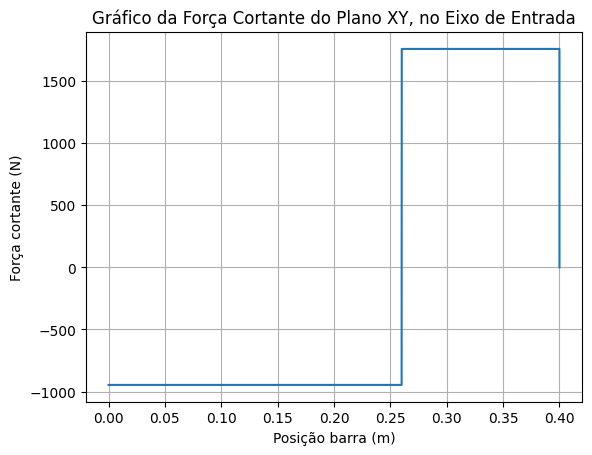

In [ ]:
z = L1+L2
Eixo = L1+L2+L3
b = L1
x = np.linspace(0,Eixo,10001)
Vxy1 = Ay*np.heaviside(x-0,1)*(x-0)**0 +FtP1*np.heaviside(x-z,1)*(x-z)**0 +By*np.heaviside(x-Eixo,1)*(x-Eixo)**0
plt.plot(x,Vxy1)
plt.grid()
plt.title('Gráfico da Força Cortante do Plano XY, no Eixo de Entrada')
plt.xlabel('Posição barra (m)')
plt.ylabel('Força cortante (N)')

Text(0, 0.5, 'Momento (N.m)')

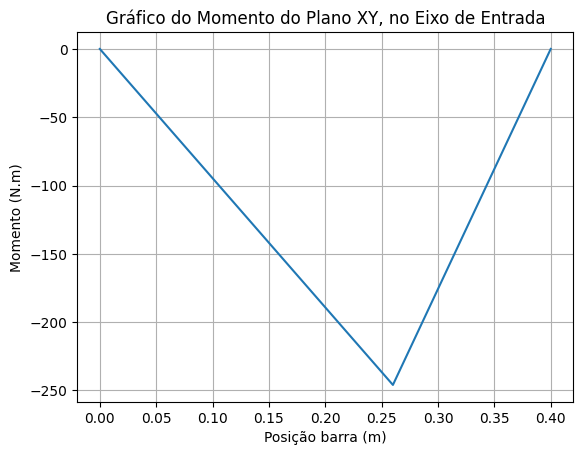

In [ ]:
Mxy1 = Ay*np.heaviside(x-0,1)*(x-0)**1 +FtP1*np.heaviside(x-z,1)*(x-z)**1 +By*np.heaviside(x-Eixo,1)*(x-Eixo)**1
plt.plot(x,Mxy1)
plt.grid()
plt.title('Gráfico do Momento do Plano XY, no Eixo de Entrada')
plt.xlabel('Posição barra (m)')
plt.ylabel('Momento (N.m)')

Text(0, 0.5, 'Força cortante (N)')

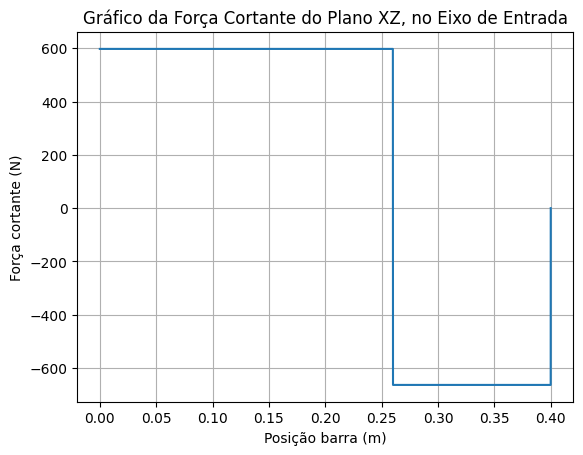

In [ ]:
Vxz1 = Az*np.heaviside(x-0,1)*(x-0)**0 +FrP1*np.heaviside(x-z,1)*(x-z)**0 +Bz*np.heaviside(x-Eixo,1)*(x-Eixo)**0
plt.plot(x,Vxz1)
plt.grid()
plt.title('Gráfico da Força Cortante do Plano XZ, no Eixo de Entrada')
plt.xlabel('Posição barra (m)')
plt.ylabel('Força cortante (N)')

Text(0, 0.5, 'Momento (N.m)')

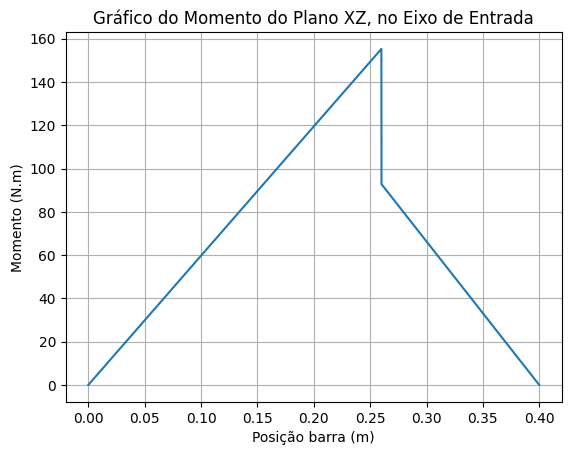

In [ ]:
Mxz1 = Az*np.heaviside(x-0,1)*(x-0)**1 +FrP1*np.heaviside(x-z,1)*(x-z)**1 +M1*np.heaviside(x-z,1)*(x-z)**0 +Bz*np.heaviside(x-Eixo,1)*(x-Eixo)**1
plt.plot(x,Mxz1)
plt.grid()
plt.title('Gráfico do Momento do Plano XZ, no Eixo de Entrada')
plt.xlabel('Posição barra (m)')
plt.ylabel('Momento (N.m)')

Text(0, 0.5, 'Força cortante (N.m)')

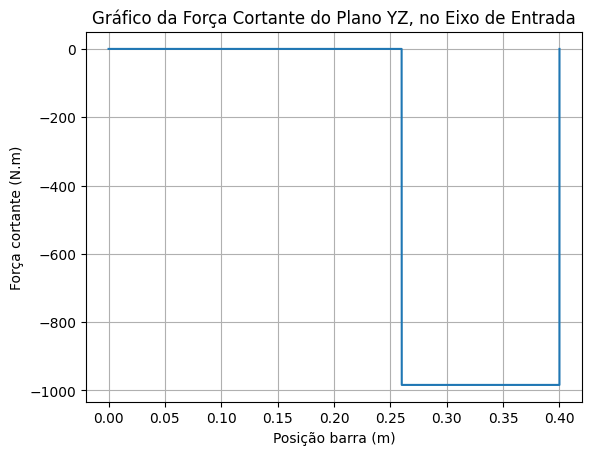

In [ ]:
Vyz1 = Ax*np.heaviside(x-0,1)*(x-0)**0 +FaP1*np.heaviside(x-z,1)*(x-z)**0 +Bx*np.heaviside(x-Eixo,1)*(x-Eixo)**0
plt.plot(x,Vyz1)
plt.grid()
plt.title('Gráfico da Força Cortante do Plano YZ, no Eixo de Entrada')
plt.xlabel('Posição barra (m)')
plt.ylabel('Força cortante (N.m)')

Text(0, 0.5, 'Momento (N.m)')

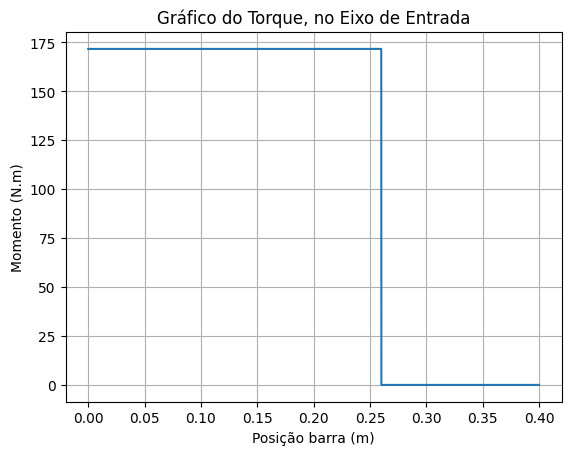

In [ ]:
Myz1 = Te*np.heaviside(x-0,1)*(x-0)**0 -Te*np.heaviside(x-z,1)*(x-z)**0 + 0*np.heaviside(x-Eixo,1)*(x-Eixo)**0
plt.plot(x,Myz1)
plt.grid()
plt.title('Gráfico do Torque, no Eixo de Entrada')
plt.xlabel('Posição barra (m)')
plt.ylabel('Momento (N.m)')

Text(0, 0.5, 'Força cortante (N)')

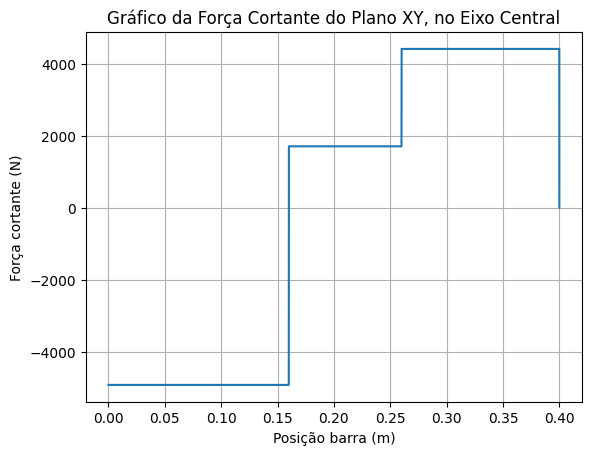

In [ ]:
Vxy2 = Cy*np.heaviside(x-0,1)*(x-0)**0 +FtG1*np.heaviside(x-z,1)*(x-z)**0 +FtP2*np.heaviside(x-b,1)*(x-b)**0 +Dy*np.heaviside(x-Eixo,1)*(x-Eixo)**0
plt.plot(x,Vxy2)
plt.grid()
plt.title('Gráfico da Força Cortante do Plano XY, no Eixo Central')
plt.xlabel('Posição barra (m)')
plt.ylabel('Força cortante (N)')

Text(0, 0.5, 'Momento (N.m)')

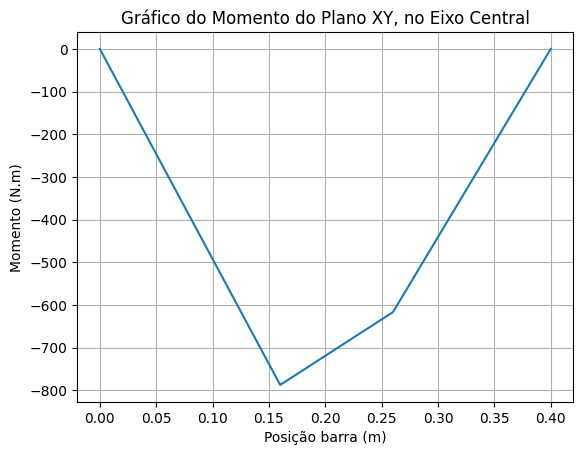

In [ ]:
Mxy2 = Cy*np.heaviside(x-0,1)*(x-0)**1 +FtG1*np.heaviside(x-z,1)*(x-z)**1 +FtP2*np.heaviside(x-b,1)*(x-b)**1 +Dy*np.heaviside(x-Eixo,1)*(x-Eixo)**1
plt.plot(x,Mxy2)
plt.grid()
plt.title('Gráfico do Momento do Plano XY, no Eixo Central')
plt.xlabel('Posição barra (m)')
plt.ylabel('Momento (N.m)')

Text(0, 0.5, 'Força cortante (N)')

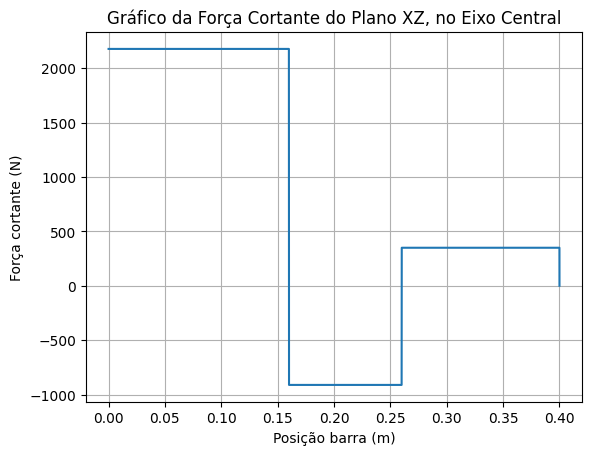

In [ ]:
Vxz2 = Cz*np.heaviside(x-0,1)*(x-0)**0 +FrG1*np.heaviside(x-z,1)*(x-z)**0 +FrP2*np.heaviside(x-b,1)*(x-b)**0 +Dz*np.heaviside(x-Eixo,1)*(x-Eixo)**0
plt.plot(x,Vxz2)
plt.grid()
plt.title('Gráfico da Força Cortante do Plano XZ, no Eixo Central')
plt.xlabel('Posição barra (m)')
plt.ylabel('Força cortante (N)')

Text(0, 0.5, 'Momento (N.m)')

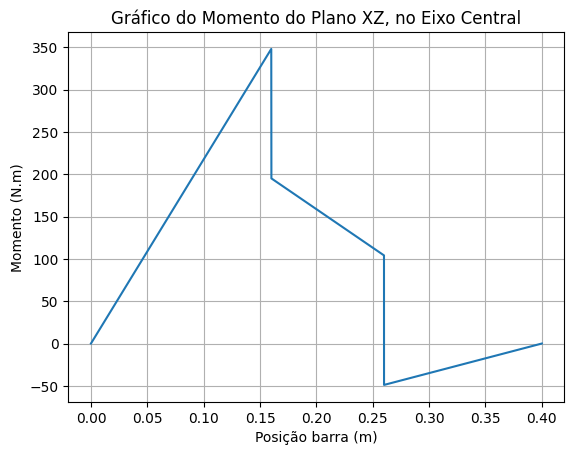

In [ ]:
Mxz2 = Cz*np.heaviside(x-0,1)*(x-0)**1 +FrP2*np.heaviside(x-b,1)*(x-b)**1 +M2*np.heaviside(x-b,1)*(x-b)**0 +FrG1*np.heaviside(x-z,1)*(x-z)**1 +M3*np.heaviside(x-z,1)*(x-z)**0 +Dz*np.heaviside(x-Eixo,1)*(x-Eixo)**1
plt.plot(x,Mxz2)
plt.grid()
plt.title('Gráfico do Momento do Plano XZ, no Eixo Central')
plt.xlabel('Posição barra (m)')
plt.ylabel('Momento (N.m)')

Text(0, 0.5, 'Força cortante (N)')

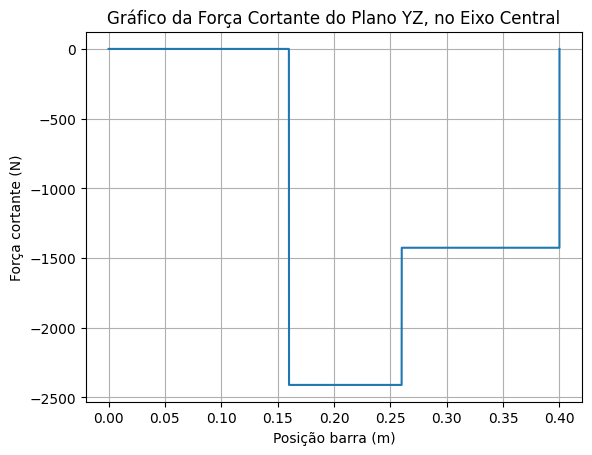

In [ ]:
Vyz2 = Cx*np.heaviside(x-0,1)*(x-0)**0 +FaG1*np.heaviside(x-z,1)*(x-z)**0 +FaP2*np.heaviside(x-b,1)*(x-b)**0 +Dx*np.heaviside(x-Eixo,1)*(x-Eixo)**0
plt.plot(x,Vyz2)
plt.grid()
plt.title('Gráfico da Força Cortante do Plano YZ, no Eixo Central')
plt.xlabel('Posição barra (m)')
plt.ylabel('Força cortante (N)')

Text(0, 0.5, 'Momento (N.m)')

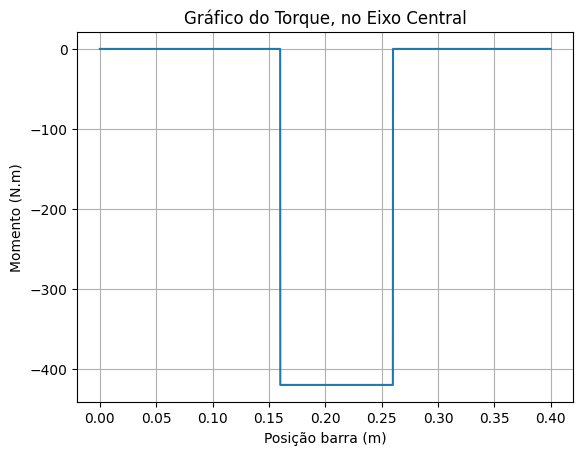

In [ ]:
Myz2 = 0*np.heaviside(x-0,1)*(x-0)**0 +Tc*np.heaviside(x-z,1)*(x-z)**0 -Tc*np.heaviside(x-b,1)*(x-b)**0 +0*np.heaviside(x-Eixo,1)*(x-Eixo)**0
plt.plot(x,Myz2)
plt.grid()
plt.title('Gráfico do Torque, no Eixo Central')
plt.xlabel('Posição barra (m)')
plt.ylabel('Momento (N.m)')

Text(0, 0.5, 'Força cortante (N.m)')

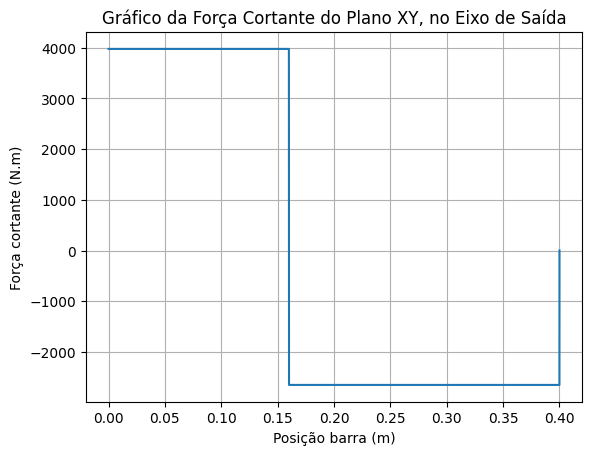

In [ ]:
Vxy3 = Ey*np.heaviside(x-0,1)*(x-0)**0 +FtG2*np.heaviside(x-b,1)*(x-b)**0 +Fy*np.heaviside(x-Eixo,1)*(x-Eixo)**0
plt.plot(x,Vxy3)
plt.grid()
plt.title('Gráfico da Força Cortante do Plano XY, no Eixo de Saída')
plt.xlabel('Posição barra (m)')
plt.ylabel('Força cortante (N.m)')

Text(0, 0.5, 'Momento (N.m)')

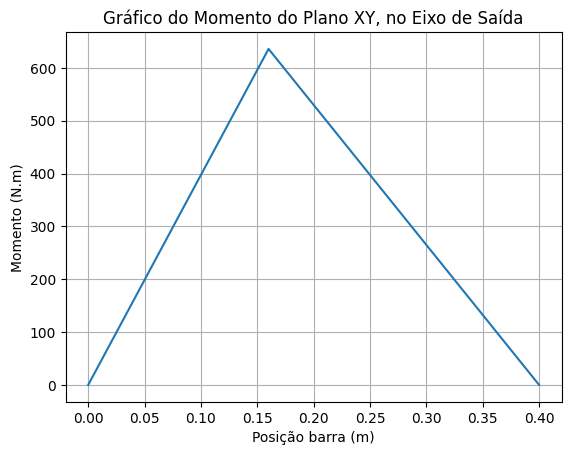

In [ ]:
Mxy3 = Ey*np.heaviside(x-0,1)*(x-0)**1 +FtG2*np.heaviside(x-b,1)*(x-b)**1 +Fy*np.heaviside(x-Eixo,1)*(x-Eixo)**1
plt.plot(x,Mxy3)
plt.grid()
plt.title('Gráfico do Momento do Plano XY, no Eixo de Saída')
plt.xlabel('Posição barra (m)')
plt.ylabel('Momento (N.m)')

Text(0, 0.5, 'Força cortante (N.m)')

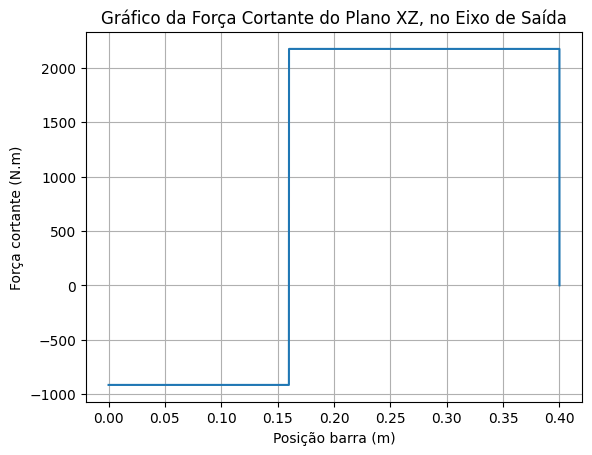

In [ ]:
Vxz3 = Ez*np.heaviside(x-0,1)*(x-0)**0 +FrG2*np.heaviside(x-b,1)*(x-b)**0 +Fz*np.heaviside(x-Eixo,1)*(x-Eixo)**0
plt.plot(x,Vxz3)
plt.grid()
plt.title('Gráfico da Força Cortante do Plano XZ, no Eixo de Saída')
plt.xlabel('Posição barra (m)')
plt.ylabel('Força cortante (N.m)')

Text(0, 0.5, 'Momento (N.m)')

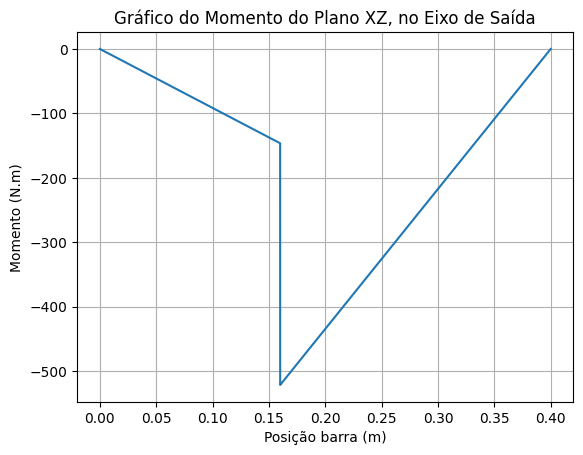

In [ ]:
Mxz3 = Ez*np.heaviside(x-0,1)*(x-0)**1 +FrG2*np.heaviside(x-b,1)*(x-b)**1 +M4*np.heaviside(x-b,1)*(x-b)**0 +Fz*np.heaviside(x-Eixo,1)*(x-Eixo)**1
plt.plot(x,Mxz3)
plt.grid()
plt.title('Gráfico do Momento do Plano XZ, no Eixo de Saída')
plt.xlabel('Posição barra (m)')
plt.ylabel('Momento (N.m)')

Text(0, 0.5, 'Força cortante (N.m)')

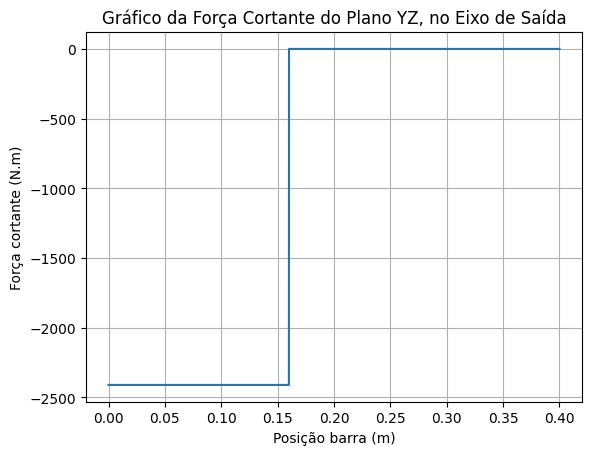

In [ ]:
Vyz3 = Ex*np.heaviside(x-0,1)*(x-0)**0 +FaG2*np.heaviside(x-b,1)*(x-b)**0 +Fx*np.heaviside(x-Eixo,1)*(x-Eixo)**0
plt.plot(x,Vyz3)
plt.grid()
plt.title('Gráfico da Força Cortante do Plano YZ, no Eixo de Saída')
plt.xlabel('Posição barra (m)')
plt.ylabel('Força cortante (N.m)')

Text(0, 0.5, 'Momento (N.m)')

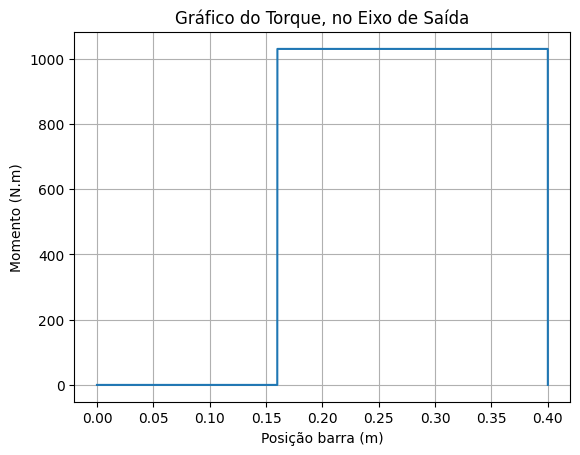

In [ ]:
Myz3 = 0*np.heaviside(x-0,1)*(x-0)**0 +Ts*np.heaviside(x-b,1)*(x-b)**0 -Ts*np.heaviside(x-Eixo,1)*(x-Eixo)**0
plt.plot(x,Myz3)
plt.grid()
plt.title('Gráfico do Torque, no Eixo de Saída')
plt.xlabel('Posição barra (m)')
plt.ylabel('Momento (N.m)')